## Project Overview
This project focuses on training and evaluating machine learning models for Acoustic Side-Channel Attacks (ASCA) on keyboard keystrokes. We extract mel-spectrogram features from keystroke sounds and train multiple models to analyze their effectiveness in classifying keystrokes. The trained models are then evaluated on a test dataset, and we compare their accuracy with the CoAtNet deep learning model.

## Workflow

 Feature Extraction: Convert keystroke audio recordings into mel-spectrograms using Librosa.
 
 Model Training: Train multiple traditional machine learning models:

 - Gaussian Naive Bayes (GaussianNB)
 - Logistic Regression (LR)
 - K-Nearest Neighbors (KNN)
 - Random Forest Classifier (RFC)

 Evaluation:
Measure accuracy on the test dataset.

Compare traditional models with the CoAtNet deep learning model.

Visualize results using a confusion matrix.

In [7]:
import torch
import pickle
import librosa
import random
import torch

import class_CoAtNet
from class_CoAtNet import CoAtNet
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor


In [2]:
coAtNet = CoAtNet()

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, f1_score, recall_score


In [4]:
random.seed(42)

In [9]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np

In [10]:
with open('updated_17.pkl', 'rb') as f:
    data = pickle.load(f)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Key                   650 non-null    int64  
 1   File                  650 non-null    object 
 2   MFCC_Full             650 non-null    object 
 3   MFCC_Mean             650 non-null    object 
 4   MFCC_Std              650 non-null    object 
 5   Spectral_Centroid     650 non-null    float64
 6   db_Mels_spectrograms  650 non-null    object 
 7   Flatten_mels          650 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 40.8+ KB


In [8]:
X = data["Flatten_mels"]
print(X.info())
print(len(X[0]))
print(X[0].shape)



<class 'pandas.core.series.Series'>
RangeIndex: 650 entries, 0 to 649
Series name: Flatten_mels
Non-Null Count  Dtype 
--------------  ----- 
650 non-null    object
dtypes: object(1)
memory usage: 5.2+ KB
None
4096
(4096,)


In [12]:
indices = data.index
indices

RangeIndex(start=0, stop=650, step=1)

In [17]:
X = np.stack(data["Flatten_mels"].values)
print(X.shape)  # Should be (650, 4096)

(650, 4096)


In [18]:
y = data['Key']
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 650 entries, 0 to 649
Series name: Key
Non-Null Count  Dtype
--------------  -----
650 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [19]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(435, 4096) (215, 4096) (435,) (215,)


In [22]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
def model_assess(model, title = "Default"):
	model.fit(X_train, y_train)
	preds = model.predict(X_test)
	print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5))
	print('F1 score   ', title, ':', round(f1_score(y_test, preds, average='macro', zero_division=0), 5))
	print('Precision', title, ':', round(precision_score(y_test, preds, average='macro', zero_division=0), 5))
	print('Recall   ', title, ':', round(recall_score(y_test, preds, average='macro', zero_division=0), 5))
	
	print()
	return preds

In [27]:

nb = GaussianNB()
model_assess(nb, "Naive Bayes")

knn = KNeighborsClassifier(n_neighbors=10)
model_assess(knn, "KNN")

svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

lg = LogisticRegression(random_state=0, solver='lbfgs')
y_predict = model_assess(lg, "Logistic Regression")

rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest");

# nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
# model_assess(nn, "Neural Nets")

# xgb = XGBClassifier(n_estimators=1000)
# model_assess(xgb, "XGBClassifier")

Accuracy Naive Bayes : 0.53488
F1 score    Naive Bayes : 0.5262
Precision Naive Bayes : 0.54775
Recall    Naive Bayes : 0.55296

Accuracy KNN : 0.5907
F1 score    KNN : 0.57806
Precision KNN : 0.63192
Recall    KNN : 0.60714

Accuracy Support Vector Machine : 0.65581
F1 score    Support Vector Machine : 0.65031
Precision Support Vector Machine : 0.69498
Recall    Support Vector Machine : 0.68045

Accuracy Logistic Regression : 0.80465
F1 score    Logistic Regression : 0.79951
Precision Logistic Regression : 0.81276
Recall    Logistic Regression : 0.81715

Accuracy Random Forest : 0.70233
F1 score    Random Forest : 0.70194
Precision Random Forest : 0.71441
Recall    Random Forest : 0.72971



In [18]:
def matrix_labels(y_password_test, predict):
    """
    Converts numeric indices of true and predicted labels into their corresponding
    alphabet letters and generates a combined list of unique labels.

    Args:
        y_password_test (list[int]): True labels as numeric indices (0-25).
        predict (list[int]): Predicted labels as numeric indices (0-25).

    Returns:
        tuple:
            - labels_list_true (list[str]): True labels as letters.
            - labels_list_predict (list[str]): Predicted labels as letters.
            - cm_labels (list[str]): Unique labels across both true and predicted sets.
    """
    # Create dictionaries for index-to-letter and letter-to-index mappings
    alfabet = 'abcdefghijklmnopqrstuvwxyz'
    number_dict = {idx: char for idx, char in enumerate(alfabet)}

    # Initialize lists
    labels_list_true = [number_dict[int(i)] for i in y_password_test]
    labels_list_predict = [number_dict[int(i)] for i in predict]
    
    # Create a set of unique labels from both lists
    cm_labels = sorted(set(labels_list_true) | set(labels_list_predict))

    return labels_list_true, labels_list_predict, cm_labels


In [19]:
def conf_matrix_style(matrix, model_name, audio_name, cm_labels):
    fig, ax = plt.subplots(dpi=300)
    plt.rcParams.update({'font.size': 8})
    ax = sns.heatmap(matrix,
                     annot=True,
                     fmt='g', 
                     xticklabels = cm_labels, 
                     yticklabels = cm_labels
                    )
    #ax.tick_params(axis='both', which='major', labelsize=20)
    #plt.gca().invert_yaxis()
    plt.xticks(size = 10)
    plt.yticks(size = 10)
    
    plt.yticks(rotation=0);
    plt.xlabel("Predicted", fontsize=10)
    plt.ylabel("Actual", fontsize=10);
    fig.savefig(f"CM_{model_name}_{audio_name}")

In [20]:
true, prdict, cm_lable = matrix_labels(y_test, y_predict)
print(true)
print(prdict)
print(cm_lable)

['r', 'o', 'l', 'p', 'g', 'c', 'b', 's', 't', 'j', 'm', 'f', 'm', 'm', 'g', 'h', 'i', 'k', 'i', 'l', 'd', 'r', 'q', 'k', 'z', 'r', 'k', 'i', 'n', 'x', 'c', 'k', 'l', 'd', 'k', 'm', 'v', 'n', 'r', 'd', 'o', 'g', 'j', 't', 'g', 'n', 'd', 'a', 'e', 'a', 'j', 'o', 'n', 'z', 'c', 'u', 'v', 'k', 'p', 'z', 'r', 'v', 't', 'q', 'i', 'z', 'p', 'g', 'q', 'e', 'o', 'x', 'y', 'v', 'z', 'b', 'v', 'n', 'l', 'l', 'b', 'b', 'j', 'u', 'g', 'v', 'c', 'j', 'q', 'i', 'g', 'i', 'z', 'a', 'g', 's', 'u', 'f', 'q', 'm', 't', 'm', 'i', 'c', 'd', 'n', 'l', 'd', 'x', 'b', 'm', 'n', 'q', 'a', 'd', 'u', 'z', 'e', 'a', 'x', 'k', 'x', 'z', 'm', 'v', 'v', 'y', 'b', 'w', 'm', 'm', 'i', 'e', 'n', 'u', 'c', 'q', 's', 'g', 'x', 'f', 'j', 'u', 'j', 'h', 'c', 'w', 't', 'b', 's', 'n', 's', 'g', 's', 'a', 'd', 'o', 'e', 'f', 'c', 'k', 'w', 'v', 'o', 'b', 'd', 'c', 'o', 'v', 'i', 'h', 'g', 'd', 'l', 'f', 'x', 'x', 'y', 'g', 'u', 'l', 't', 'q', 'g', 'e', 'q', 'o', 'm', 'p', 'b', 'a', 'k', 'd', 'h', 'd', 'i', 'q', 'r', 'j', 'o',

In [21]:
conf_matrix = confusion_matrix(matrix_labels(y_test, y_predict)[0], matrix_labels(y_test, y_predict)[1], labels=matrix_labels(y_test, y_predict)[2])

In [22]:
import seaborn as sns

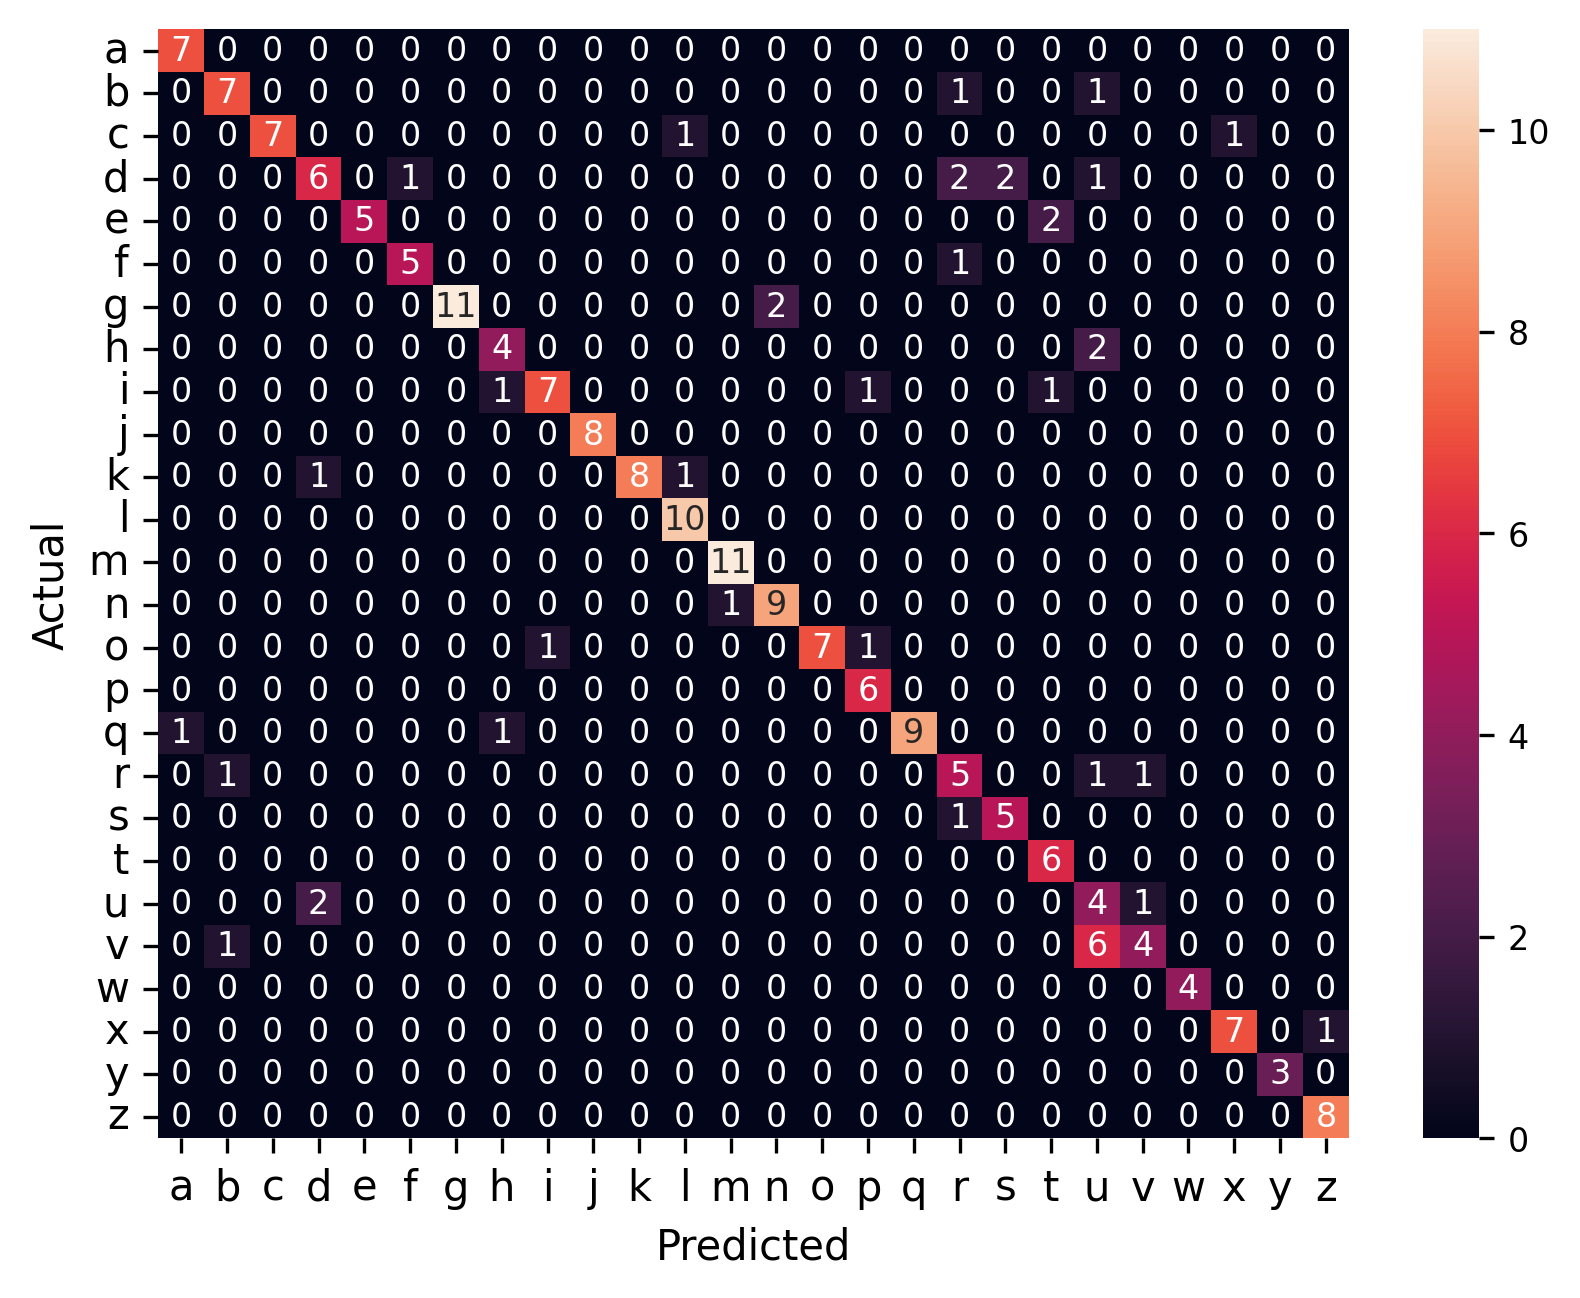

In [23]:
conf_matrix_style(matrix = conf_matrix, model_name = 'LR', audio_name = 'test_set', cm_labels = matrix_labels(y_test, y_predict)[2])

In [24]:
model_path = '/Users/anastasiia/Documents/Study/Diplom/programs/audio/CoAtNet_Model_lr=5e-4 (3).pkl'

In [25]:
coAtNet.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

/var/folders/0t/pv5cdp3j0jbcn15_b7vw19v00000gn/T/ipykernel_77636/1349172334.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coAtNet.load_state_dict(torch.load(model_path

<All keys matched successfully>

In [76]:
class MyDataset(Dataset):
    def __init__(self, file_name, transform = None, aug = None):
        df = file_name
        self.transform = transform
        self.aug = aug
        self.labels = df['Key']
        self.values = df['File']
        
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        label = self.labels.iloc[index]
        value = self.values.iloc[index]
        waveform = self.values.iloc[index]
        
        label = self.labels.iloc[index]
        if self.transform:
            #waveform = waveform.numpy()
            waveform = waveform.flatten()
            waveform = self.transform(waveform)
        if self.aug:
            waveform = self.aug(waveform)
            

        return waveform, label

In [68]:
class ToMelSpectrogram:
    def __call__(self, samples):
        return librosa.feature.melspectrogram(y = samples, sr = sr, n_mels=64, n_fft=1024, hop_length=226)

In [69]:
transform = Compose([
    ToMelSpectrogram(),
    ToTensor()])

In [70]:
df = '/Users/anastasiia/Documents/Study/Diplom/programs/audio/audio_df_17.pkl'
with open(df, 'rb') as f:
    coAtNet_df = pickle.load(f)
coAtNet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Key     650 non-null    int64 
 1   File    650 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.3+ KB


In [77]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(coAtNet_df, test_size=0.33)
print(len(train))
print(len(test))

435
215


In [78]:
val_dataset = MyDataset(test, transform = transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [61]:
sr = 48000

In [85]:
def evaluation(model, loader):
    val_data_acc = []
    model.eval()
    correct_labels = []
    predicted_labels = []
    with torch.no_grad():
                correct = 0
                total = 0
                for inputs, labels in loader:
                    caracter_lab = []
                    caracter_pred = []
                    
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    
                    
                    correct_labels.extend(labels)
                    predicted_labels.extend(predicted)
                val_data_acc.append(correct/total)
                return correct_labels, predicted_labels

In [90]:
y_test, y_predict = evaluation(coAtNet, val_loader)

In [91]:
def print_model_res(title, y_test, preds):
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5))
    print('F1 score   ', title, ':', round(f1_score(y_test, preds, average='macro', zero_division=0), 5))
    print('Precision', title, ':', round(precision_score(y_test, preds, average='macro', zero_division=0), 5))
    print('Recall   ', title, ':', round(recall_score(y_test, preds, average='macro', zero_division=0), 5))

    print()
print_model_res('CoAtNet',y_test, y_predict)

Accuracy CoAtNet : 0.93953
F1 score    CoAtNet : 0.93496
Precision CoAtNet : 0.93806
Recall    CoAtNet : 0.93985



In [92]:
conf_matrix = confusion_matrix(matrix_labels(y_test, y_predict)[0], matrix_labels(y_test, y_predict)[1], labels=matrix_labels(y_test, y_predict)[2])

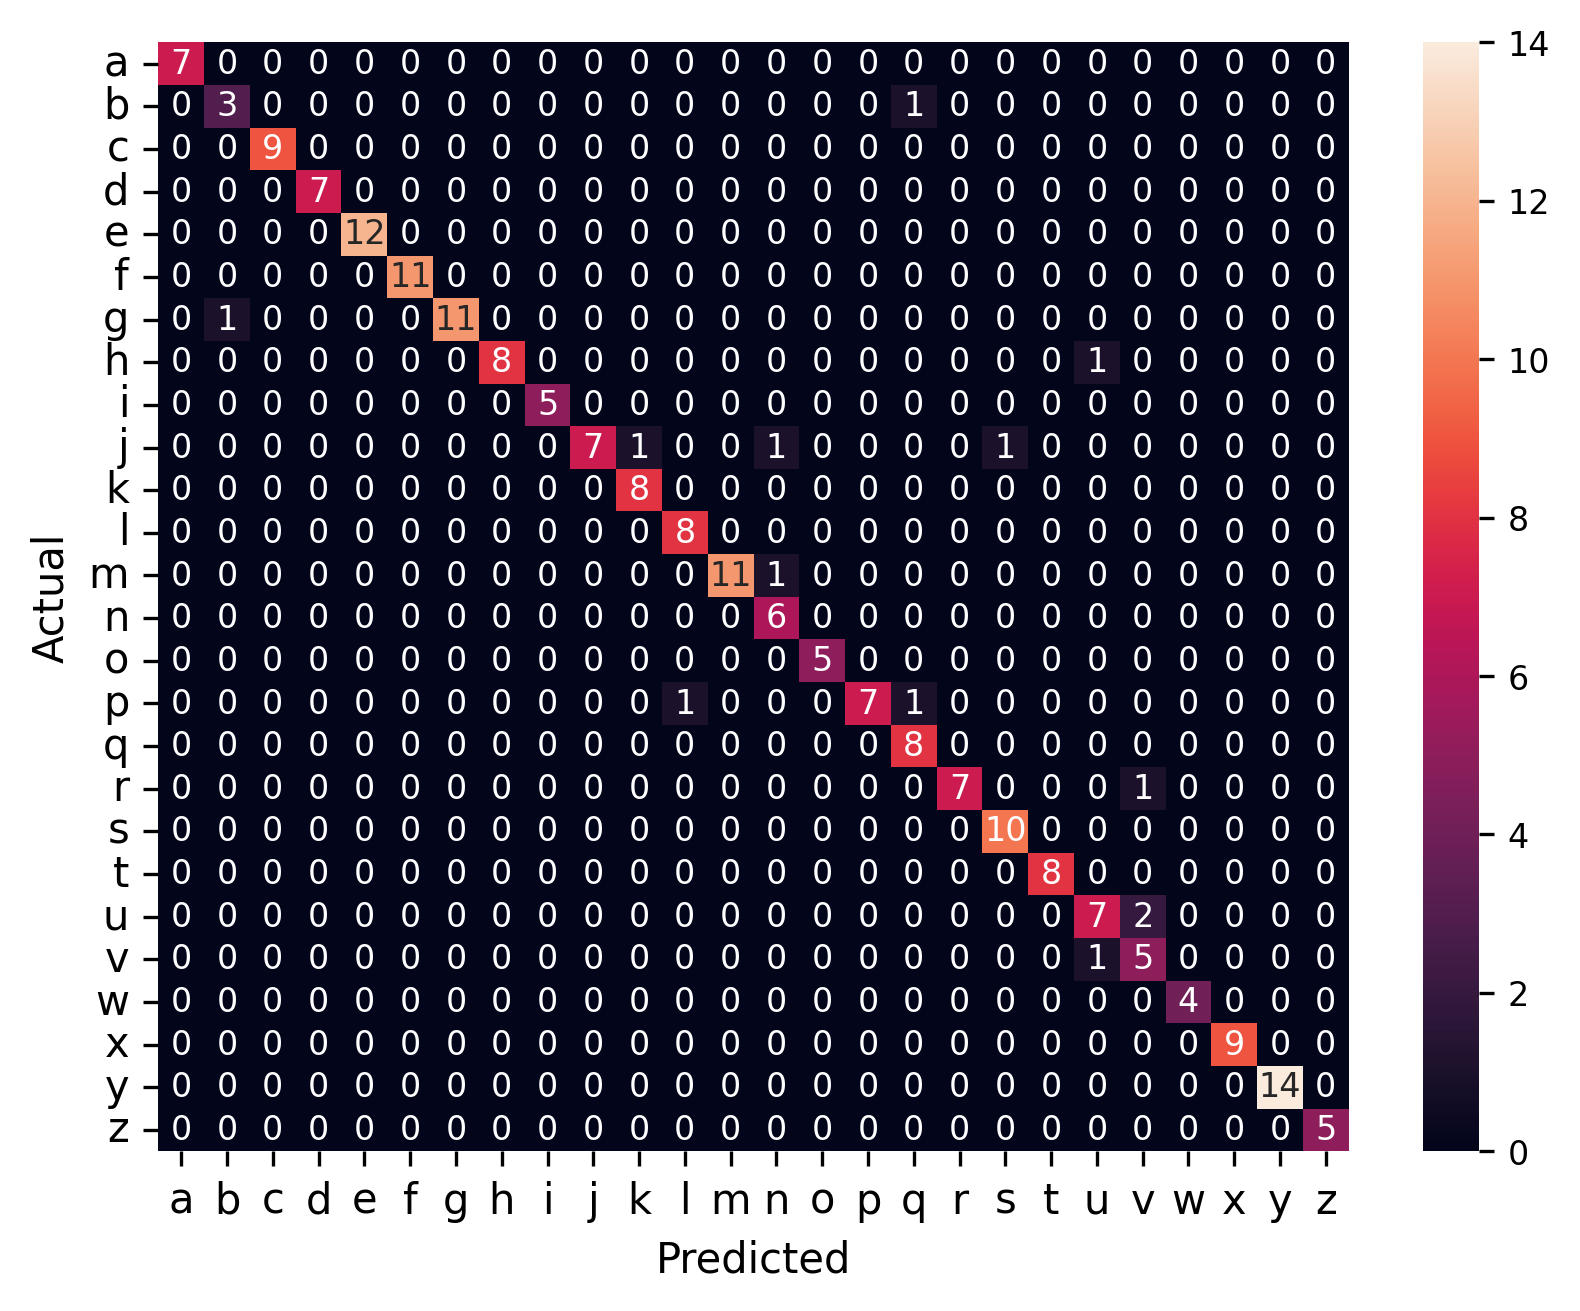

In [93]:
conf_matrix_style(matrix = conf_matrix, model_name = 'CoAtNet', audio_name = 'test_set', cm_labels = matrix_labels(y_test, y_predict)[2])